In [297]:
import numpy as np
import cv2
import imutils
import skimage

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

In [298]:
def show_img(image):
    plt.figure(figsize=(16,16))
    plt.imshow(image)

In [299]:
path = r'overhead-science-3.png'
img = cv2.imread(path)

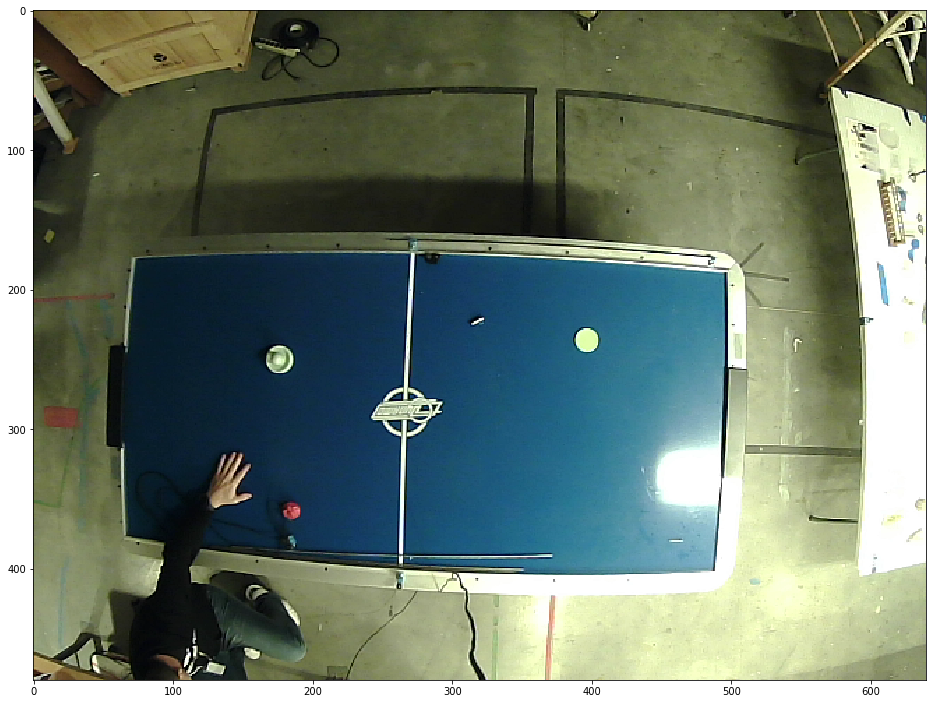

In [301]:
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
show_img(rgb)

In [302]:
t, black = cv2.threshold(rgb, 20, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
mask = ~black[:,:,2]
#show_img(mask)

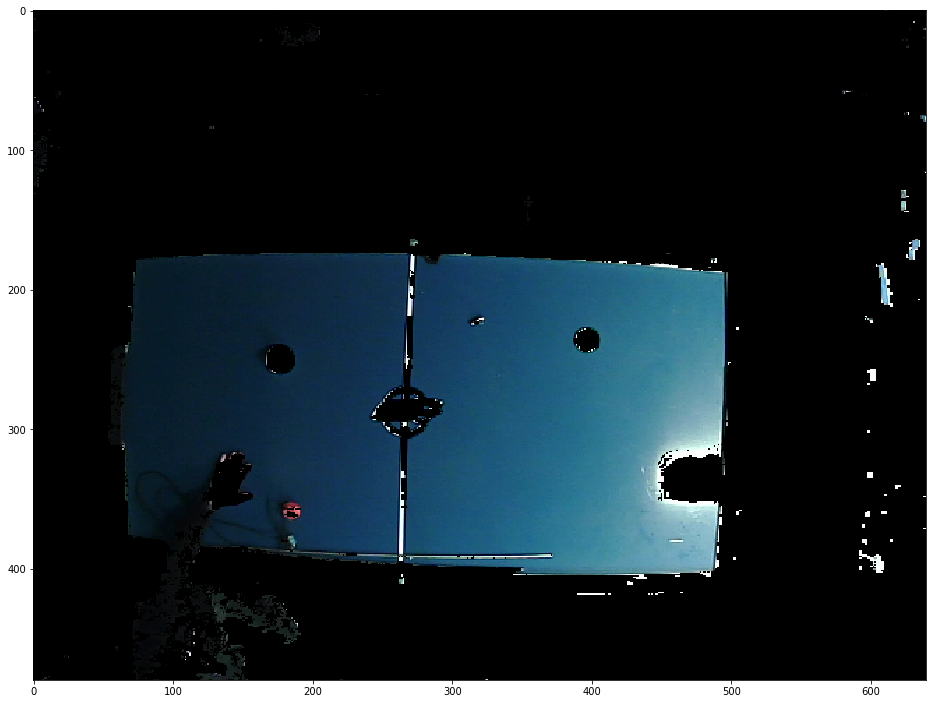

In [323]:
hsv = cv2.cvtColor(rgb, cv2.COLOR_RGB2HSV)

blue_lower=np.array([80,0,0],np.uint8)
blue_upper=np.array([255,255,255],np.uint8)
blue_mask = cv2.inRange(hsv, blue_lower, blue_upper) 
  
blue = cv2.bitwise_and(rgb, rgb, mask=blue_mask)
show_img(blue)

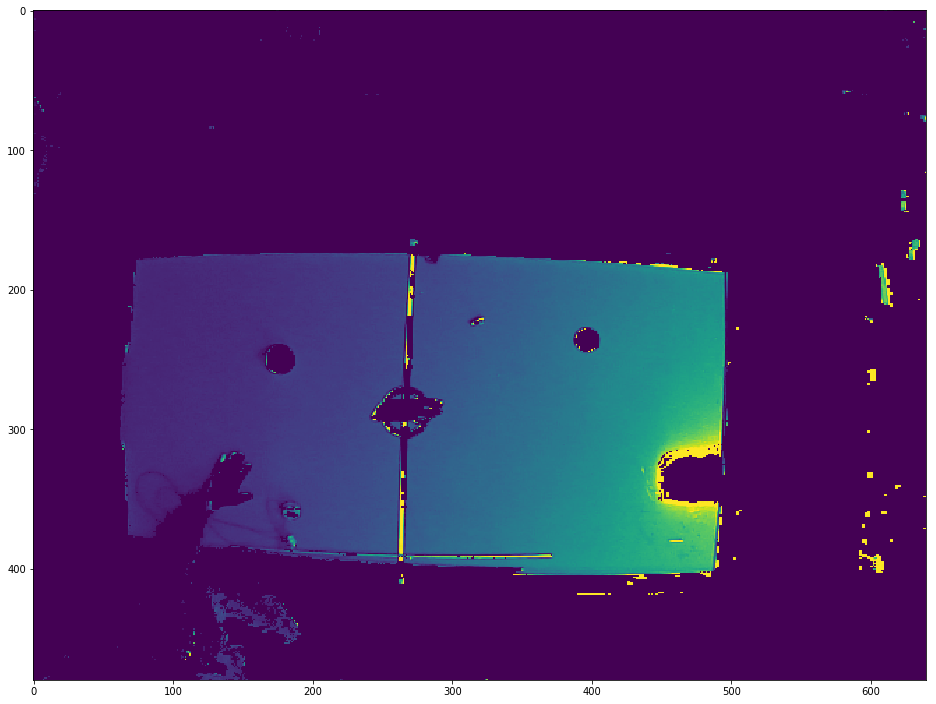

In [324]:
masked = blue[:,:,1] & mask
show_img(masked)

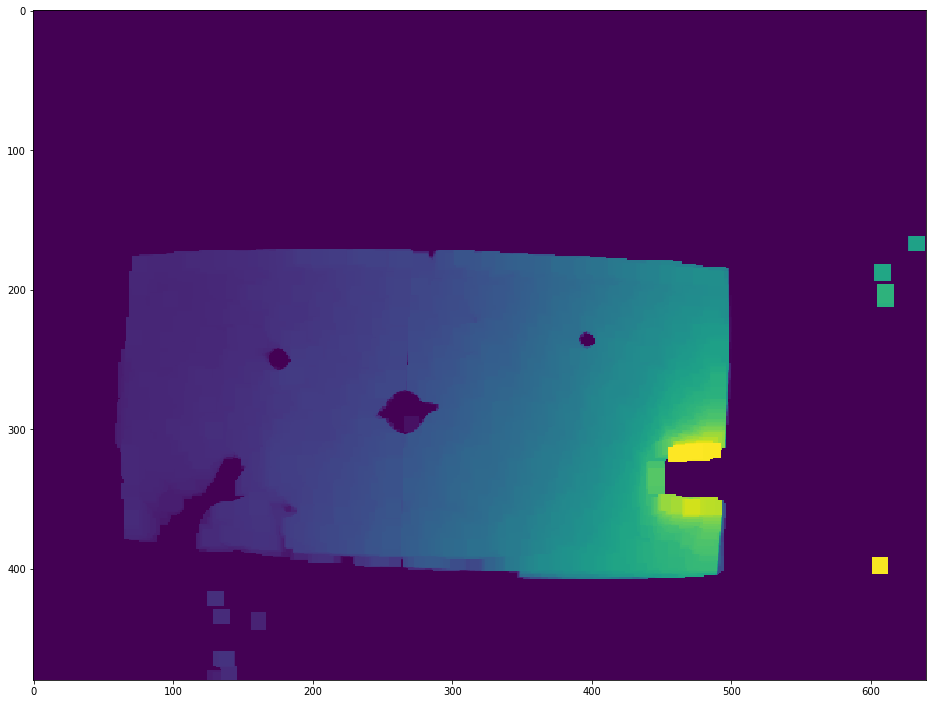

In [325]:
eroded = cv2.erode(masked, None, iterations=2)
fuzzed = cv2.dilate(eroded, None, iterations=5)
show_img(fuzzed)

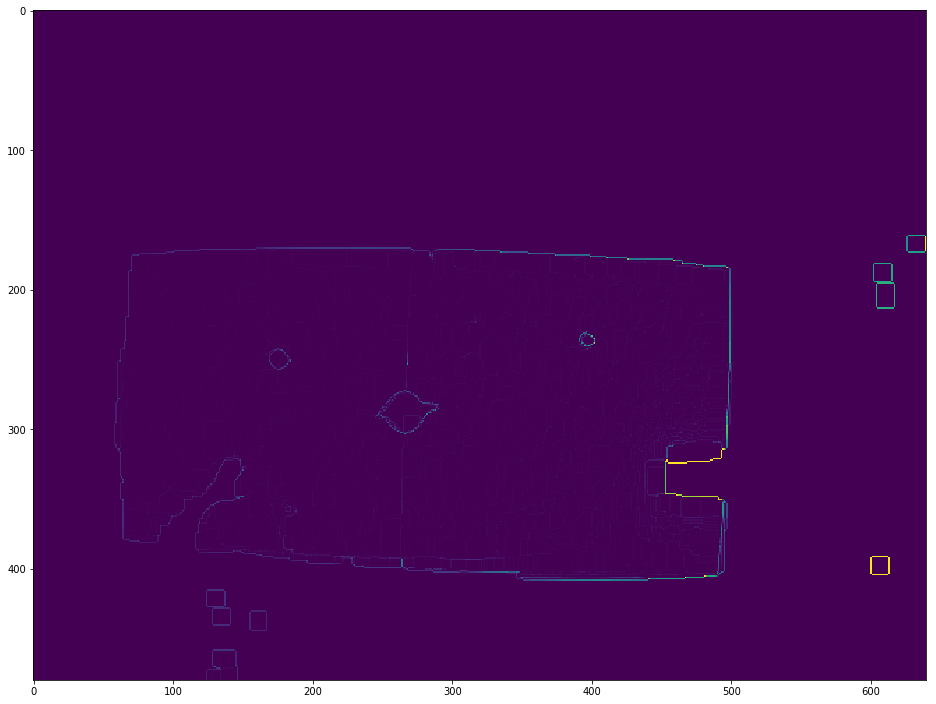

In [304]:
## edges are less work
edges = cv2.Laplacian(fuzzed, cv2.CV_8UC1)
show_img(edges)

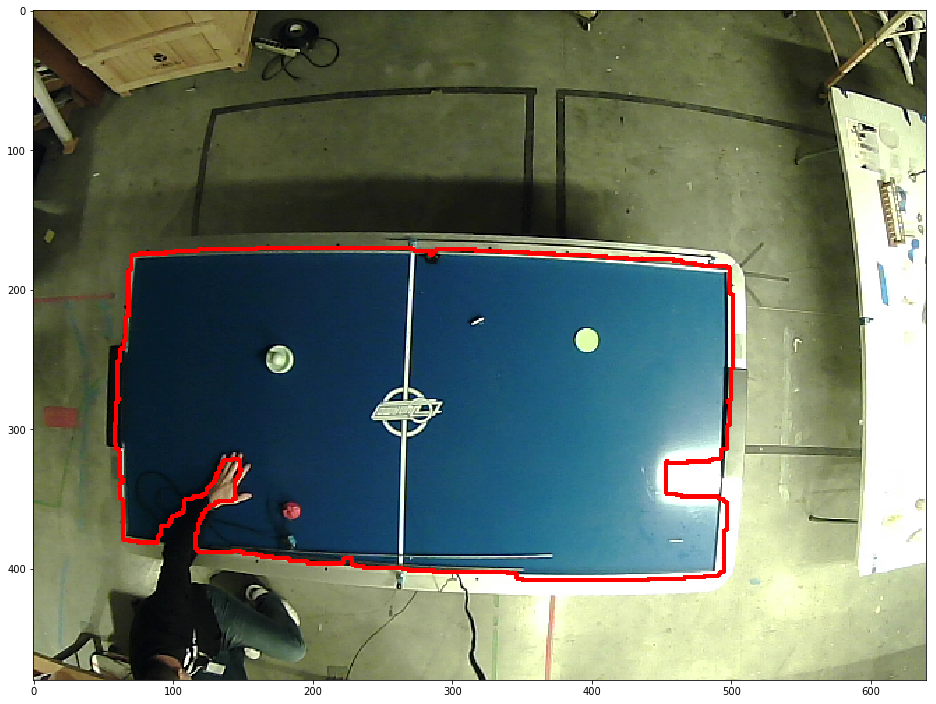

In [306]:
## find largest external blob
im2, outer_contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
max_contour = max(outer_contours, key = cv2.contourArea)
test = cv2.drawContours(rgb.copy(), [max_contour], -1, (255,0,0), 2)
show_img(test)

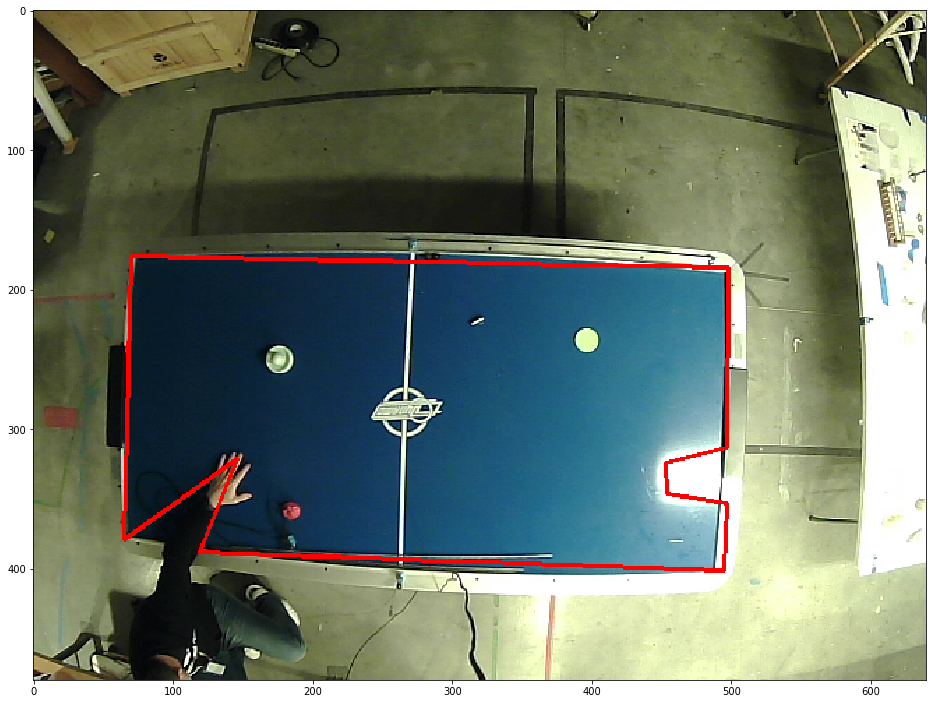

In [307]:
approx = cv2.approxPolyDP(max_contour, 0.01*cv2.arcLength(max_contour, True), True)
test = cv2.drawContours(rgb.copy(), [approx], -1, (255,0,0), 2)
show_img(test)

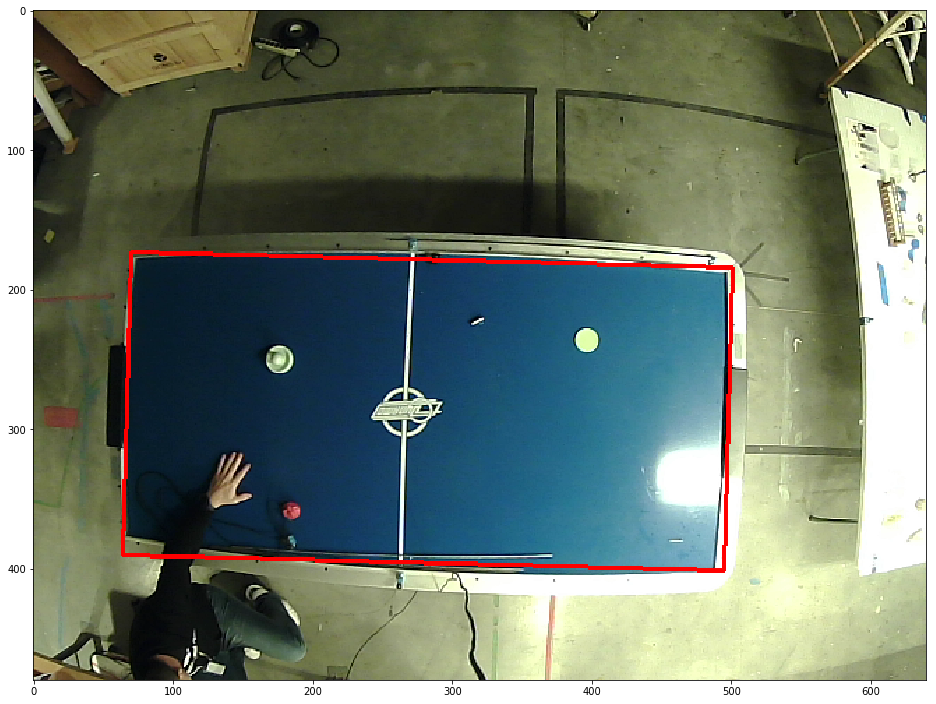

In [308]:
## translate playing area to a clean rect

rect = cv2.minAreaRect(approx)
box = cv2.boxPoints(rect)
box = np.int0(box)

from imutils import perspective
ordered = np.int0(perspective.order_points(box))

disp = rgb.copy()
cv2.drawContours(disp,[ordered],0,(255,0,0),2)
show_img(disp)

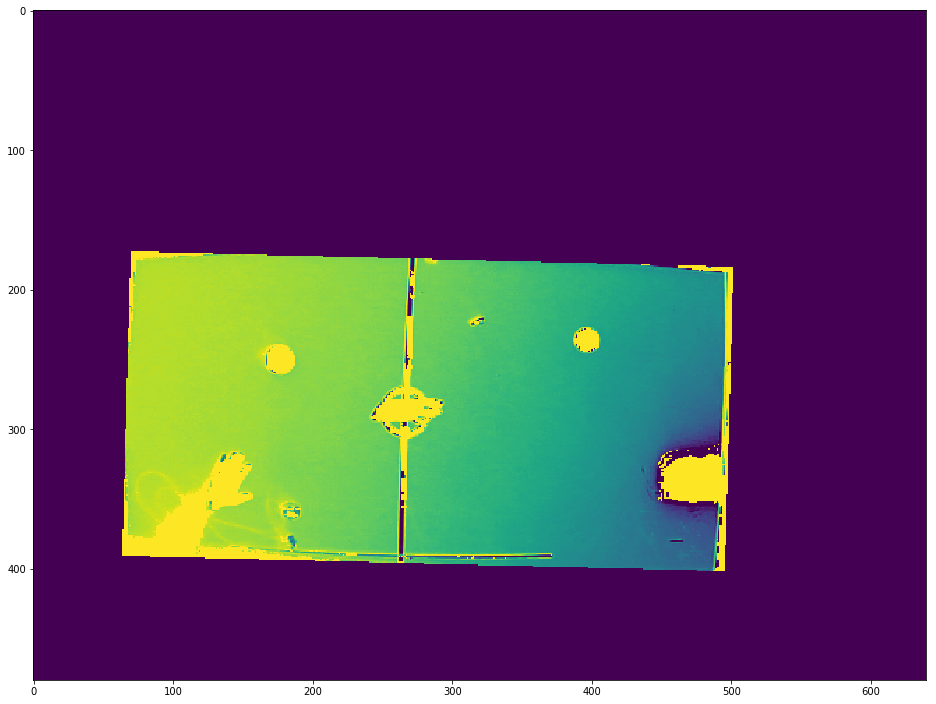

In [418]:
not_blue = ~masked
table = np.zeros_like(masked)
cv2.fillPoly(table, [box], 255)
not_blue = not_blue & table
show_img(not_blue)

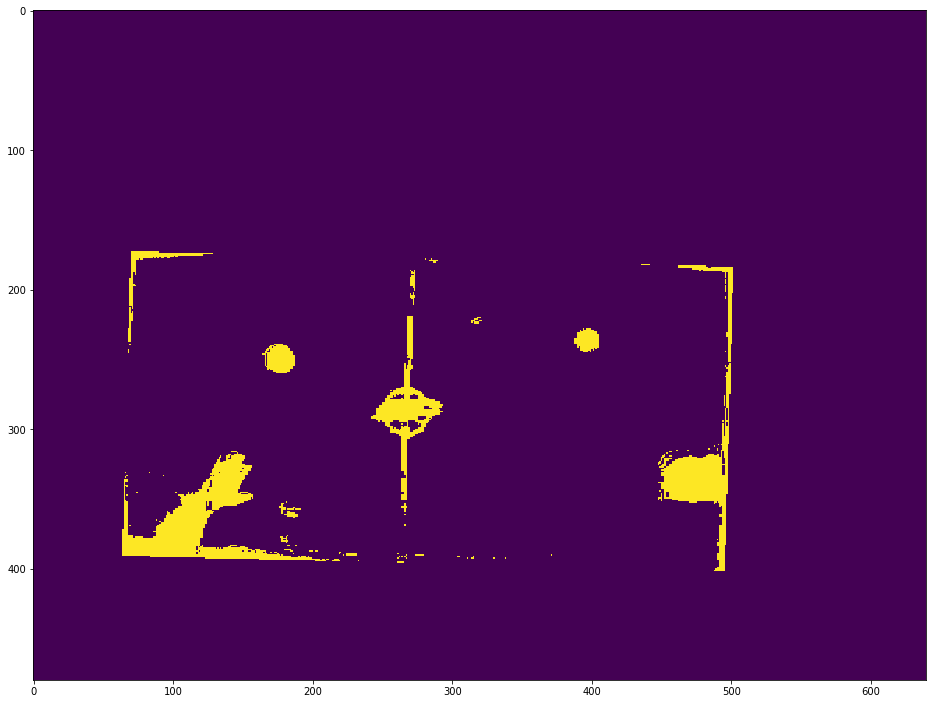

In [419]:
t, thresh = cv2.threshold(not_blue, 254, 255, cv2.THRESH_BINARY, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
show_img(thresh)

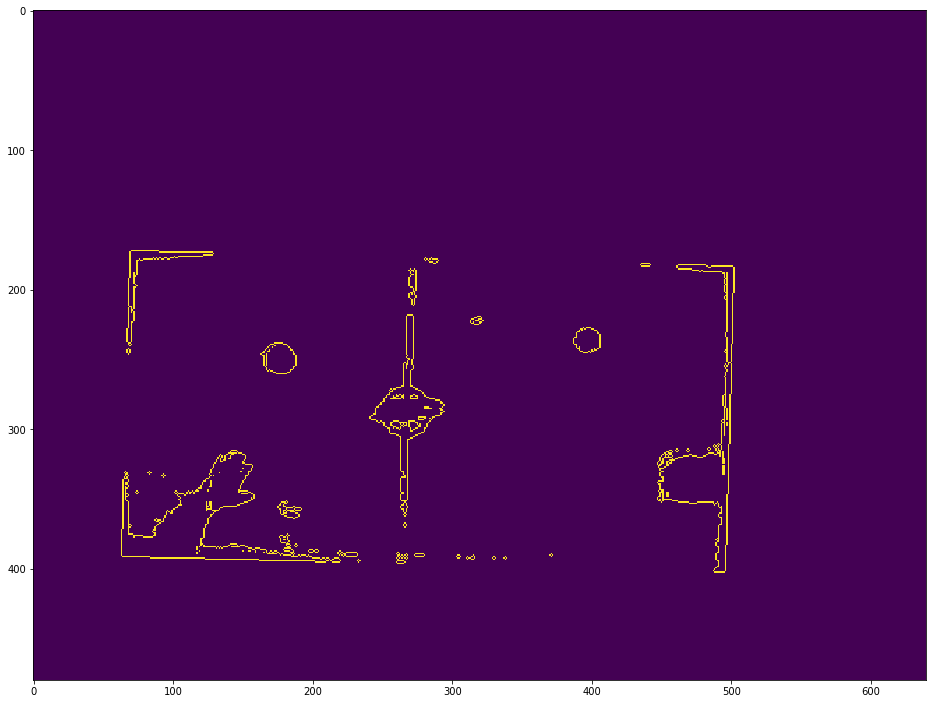

In [420]:
## edges are less work
laplacian = cv2.Laplacian(thresh,cv2.CV_8UC1)
#edges = cv2.Canny(not_blue, 1, 1)
show_img(laplacian)

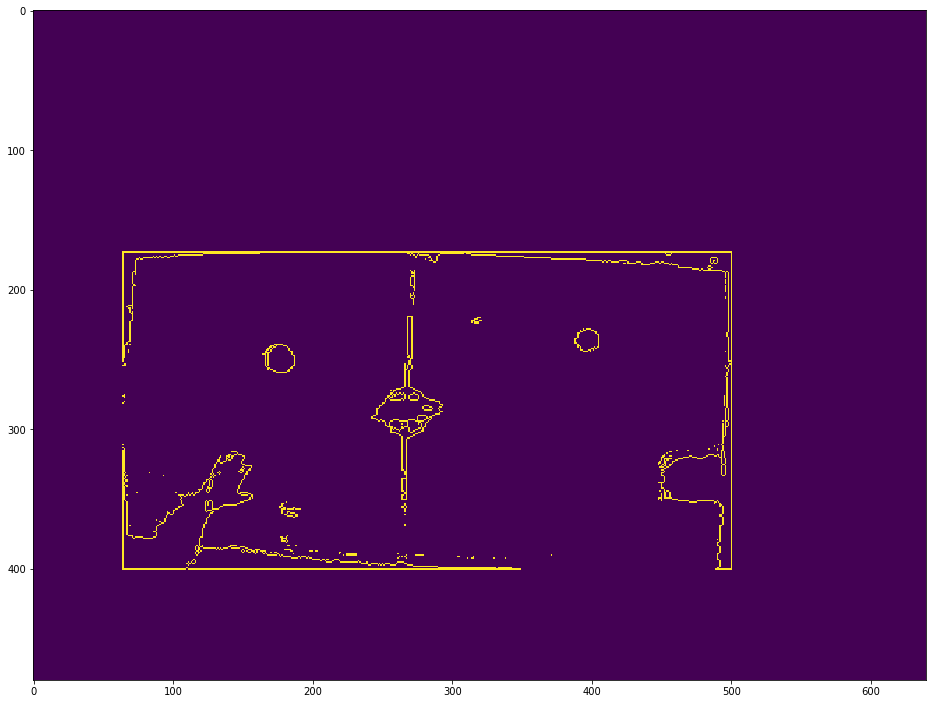

In [382]:
## get all of the shapes
im2, all_contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)                                                   
test = cv2.drawContours(np.zeros_like(laplacian), all_contours, -1, (255,255,255), 1)
show_img(test)

In [387]:
## filter out non-circular shapes

def is_circle(c):
#    polys = len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True))
#    if polys < 8 or polys > 15:
#        return False

    center, radius = cv2.minEnclosingCircle(c)
    area = get_area(c)
    circle_area = 3.14*radius*radius
    if abs(area-circle_area) > .5 * area:
        return False
    
    return True

circular_contours = [c for c in all_contours if is_circle(c)]

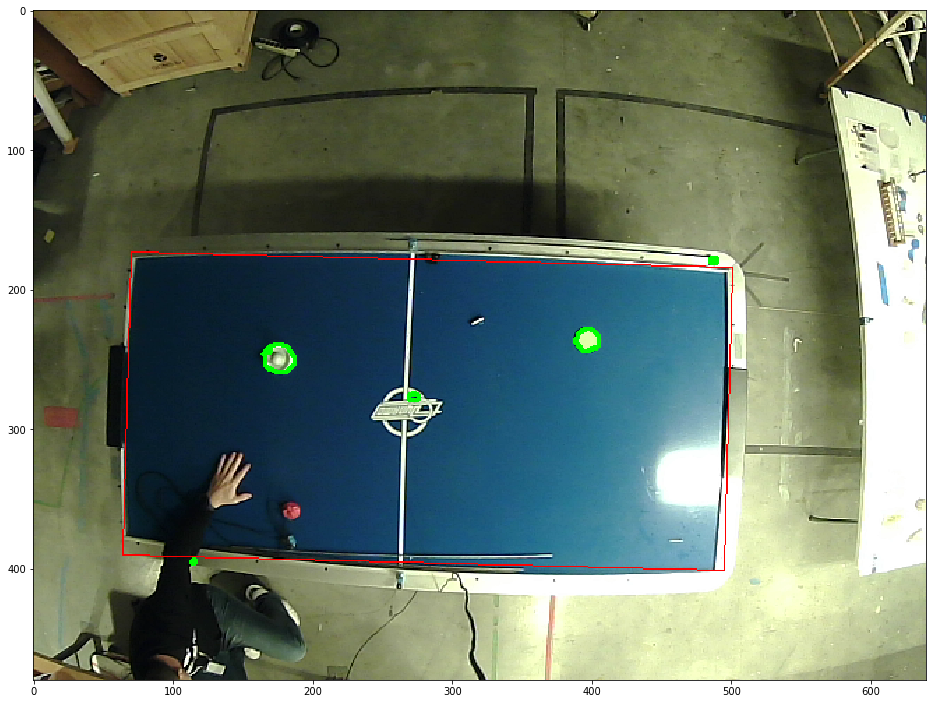

In [388]:
## put it all together

disp = rgb.copy()
cv2.drawContours(disp, [box], 0, (255, 0, 0), 1)
cv2.drawContours(disp, circular_contours, -1, (0,255,0), 2)
show_img(disp)

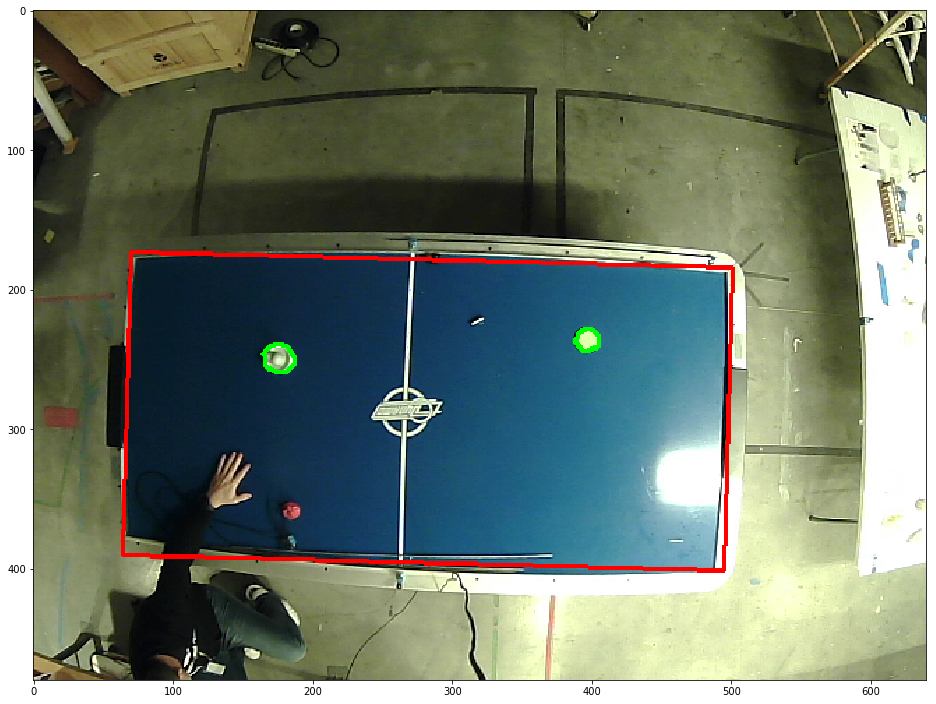

In [412]:
## filter out large shapes

def get_area(c):
    m = cv2.moments(c)
    return m['m00']

small_contours = [c for c in circular_contours if get_area(c) < 400 and get_area(c) > 50]
test = cv2.drawContours(rgb.copy(), small_contours, -1, (0,255,0), 2)
cv2.drawContours(test, [box], 0, (255, 0, 0), 2)
show_img(test)

In [19]:
def annotate(img):
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ## isolate HUE
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:,:,1:] = 0
    t, hue = cv2.threshold(hsv, 50, 255, cv2.THRESH_BINARY)
    hue = ~hue[:,:,0]

    ## mask out black
    t, blue = cv2.threshold(rgb, 20, 255, cv2.THRESH_BINARY_INV, cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
    mask = ~blue[:,:,2]
    masked = mask & hue
    
    ## denoise
    kernel = np.ones((1, 1))
    opened = cv2.morphologyEx(masked, cv2.MORPH_OPEN, kernel)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, np.ones((1,5)))

    ## edges are less work
    laplacian = cv2.Laplacian(closed,cv2.CV_8UC1)

    ## find largest external blob
    im2, outer_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(outer_contours, key = cv2.contourArea)

    ## translate playing area to a clean rect
    rect = cv2.minAreaRect(max_contour)
    box = np.int0(cv2.boxPoints(rect))
    print(box)

    ## get all of the shapes
    im2, all_contours, hierarchy = cv2.findContours(laplacian, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

    ## isolate the shapes inside the table area
    contours_in_box = [c for c in all_contours if not (min(c[:,0,0]) <= min(box[:,0]) or max(c[:,0,0]) >= max(box[:,0]) or min(c[:,0,1]) <= min(box[:,1]) or max(c[:,0,1]) >= max(box[:,1]))]

    ## filter out large shapes
    def get_area(c):
        m = cv2.moments(c)
        return m['m00']
    max_area = get_area(max_contour)
    small_contours = [c for c in contours_in_box if (get_area(c) * 100 / max_area) < 50 and (get_area(c) * 100 / max_area) > 0.1]

    ## filter out non-circular shapes
    def is_circle(c):
        polys = len(cv2.approxPolyDP(c,0.01*cv2.arcLength(c,True),True))
        if polys < 8 or polys > 15:
            return False

        center, radius = cv2.minEnclosingCircle(c)
        area = get_area(c)
        circle_area = 3.14*radius*radius
        if abs(area-circle_area) > .5 * area:
            return False

        return True

    circular_contours = [c for c in small_contours if is_circle(c)]

    ## put it all together
    cv2.drawContours(rgb, [box], 0, (255, 0, 0), 2)
    cv2.drawContours(rgb, circular_contours, -1, (0,255,0), 2)
    return rgb

[[535 433]
 [ 80 432]
 [ 81 180]
 [536 182]]


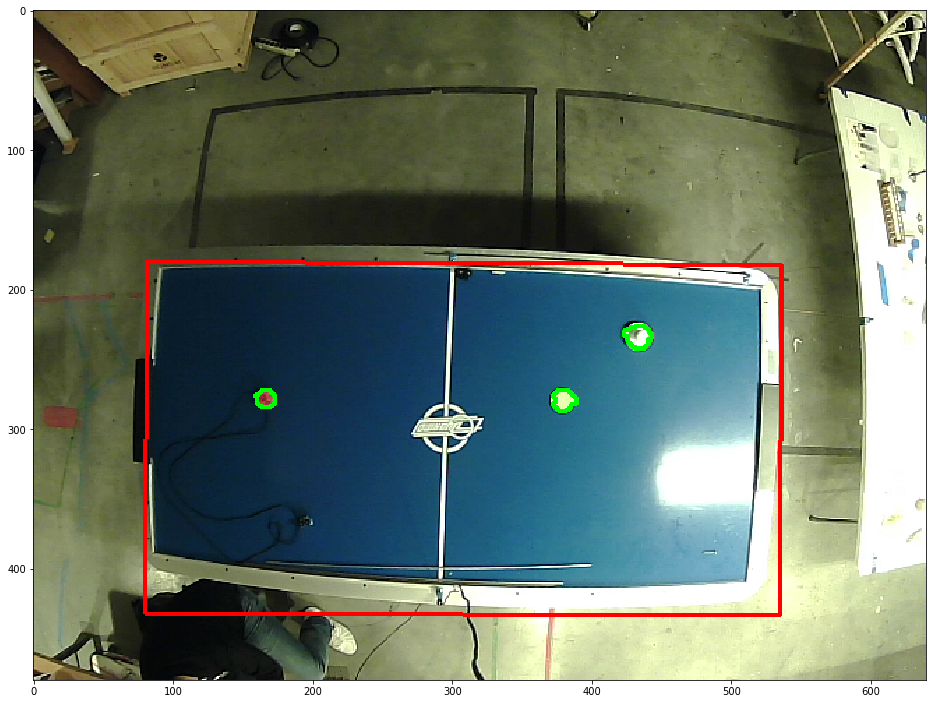

In [20]:
annotated = annotate(img)
show_img(annotated)